In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

from datetime import date
import warnings

from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import importlib
import scripts.Strategy as ss

%load_ext autoreload
%autoreload 2
#importlib.reload(ss) #above magic works so won't need to manual reload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
def create_dogleash(df, win):
    
    dog_leash=df.copy()
    dog_leash=dog_leash.rolling(window=win).mean()
    dog_leash.dropna(inplace=True)
    c=np.polyfit(dog_leash.iloc[:, 0], dog_leash.iloc[:, 1], 1)
    dog_leash['Dog_leash']=dog_leash.iloc[:, 1]-c[0]*dog_leash.iloc[:, 0]
    dog_leash=dog_leash[['Dog_leash']]
    newcol_name=f'Dogleash_{win}'
    dog_leash.rename(columns={'Dog_leash':newcol_name}, inplace=True)
    
    return dog_leash

In [12]:
#data prepare
warnings.filterwarnings('ignore')
start=date(1990, 1, 1)
end=date(2020, 11, 23)

stock_list=['BABA', 'BBY']
stock_pair=yf.download(stock_list, start, end, progress = False)

stock_pair=stock_pair[['Adj Close']].copy()
stock_pair.dropna(how='any', axis=0, inplace=True)
stock_pair.columns=stock_pair.columns.droplevel()
stock_pair.index=pd.DatetimeIndex(stock_pair.index)
#stock_pair.head()
dogleash_5=create_dogleash(stock_pair, 5)
test_data=pd.merge(stock_pair, dogleash_5, how='outer', on='Date')
dogleash_20=create_dogleash(stock_pair, 20)
test_data=pd.merge(test_data, dogleash_20, how='outer', on='Date')

c=np.polyfit(test_data.iloc[:, 0], test_data.iloc[:, 1], 1)
test_data['realcombo']=-test_data.iloc[:,0]*c[0]+test_data.iloc[:,1]
#test_data.dropna(how='any', axis=0, inplace=True)
test_data=test_data.reset_index()

In [102]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 6 columns):
Date           1556 non-null datetime64[ns]
BABA           1556 non-null float64
BBY            1556 non-null float64
Dogleash_5     1552 non-null float64
Dogleash_20    1537 non-null float64
realcombo      1556 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 73.1 KB


In [ ]:
#################################################run model and get model's info###########################################
model=SARIMAX(test_data.loc[:,'realcombo'] , order=(9, 0, 14))
results=model.fit()

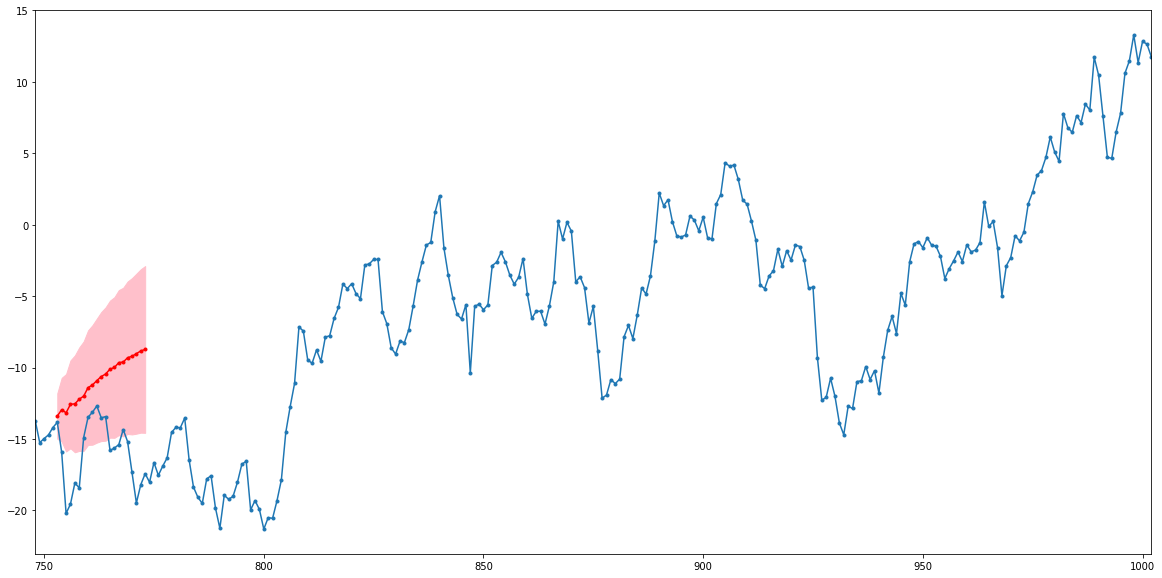

In [110]:
index=693+60
test_start=-len(test_data)+index
back_forecast=results.get_prediction(start=test_start, end=test_start+20, dynamic=True)
mean_forecast=back_forecast.predicted_mean
conf_intervals=back_forecast.conf_int(alpha=0.30)

#print(intervals_5)
plt.figure(figsize=(20,10))
test_data.realcombo[test_start-5:test_start+250].plot(marker='.')
plt.plot(mean_forecast.index, mean_forecast.values, color='red', marker='.', label='forecast_mean')

selected='realcombo'
plt.fill_between(conf_intervals.index, conf_intervals[f'lower {selected}'], conf_intervals[f'upper {selected}'], color='pink')
plt.show()

#first_var=test_data.iloc[len(test_data.index)+test_start-3,3]-mean_forecast[len(test_data.index)+test_start-3]
#second_var=test_data.iloc[len(test_data.index)+test_start-2,3]-mean_forecast[len(test_data.index)+test_start-2]
#third_var=test_data.iloc[len(test_data.index)+test_start-1,3]-mean_forecast[len(test_data.index)+test_start-1]


In [103]:
test_start=-1400
position_0=0
position_1=0
temp_list=[]
action='-'
signal_1='-'
index_0=len(test_data)+test_start
model_start=test_start #end of the initiation section

alpha_lvl=0.3 #setting parameters
forecast_len=20
trend_tolerance=0.05

for index in range(index_0, len(test_data)-20):
    mod_logic_1=index==index_0
    mod_logic_2=index==(mean_forecast.index[-1])
    if mod_logic_1 or mod_logic_2:
        model_start=-len(test_data)+index
        back_forecast=results.get_prediction(start=model_start, end=model_start+forecast_len, dynamic=True)
        mean_forecast=back_forecast.predicted_mean
        conf_intervals=back_forecast.conf_int(alpha=alpha_lvl)
        
    print(model_start)

    if test_data.loc[index, 'realcombo']<conf_intervals.loc[index, f'lower {selected}']:
        signal_1='up'
    elif test_data.loc[index, 'realcombo']>conf_intervals.loc[index, f'upper {selected}']:
        signal_1='down'
    else:
        signal_1='-'
    
    print(signal_1)
    if signal_1!='-':
        model_start=-len(test_data)+index
        back_forecast=results.get_prediction(start=model_start, end=model_start+forecast_len, dynamic=True)
        mean_forecast=back_forecast.predicted_mean
        conf_intervals=back_forecast.conf_int(alpha=alpha_lvl)
    
        if ((mean_forecast[index+forecast_len]/mean_forecast[index])-1)>trend_tolerance:
            signal_2='up'
        elif ((mean_forecast[index+forecast_len]/mean_forecast[index])-1)<-trend_tolerance:
            signal_2='down'
        else:
            signal_2='-'
        
        if signal_1=='up' and signal_2=='up':
            position_0=position_1
            position_1=test_data.loc[index,'realcombo']
            action='L'
            temp_list.append((index, position_0, position_1, action))
            action='-'
        if signal_1=='down' and signal_2=='down':
            position_0=position_1
            position_1=-test_data.loc[index,'realcombo']
            action='S'
            temp_list.append((index, position_0, position_1, action))
            action='-'

        signal_1='-'        
        
    print(index)
    print(mean_forecast)
    print(signal_1)
    print(model_start)

-1400
-
156
156   -0.657835
157   -0.521342
158   -0.714742
159   -0.643018
160   -0.815378
161   -0.667242
162   -0.790262
163   -0.921804
164   -0.867507
165   -0.963903
166   -0.944733
167   -1.078418
168   -0.895385
169   -0.964770
170   -0.870442
171   -0.785585
172   -0.738338
173   -0.626209
174   -0.625693
175   -0.457808
176   -0.534092
dtype: float64
-
-1400
-1400
-
157
156   -0.657835
157   -0.521342
158   -0.714742
159   -0.643018
160   -0.815378
161   -0.667242
162   -0.790262
163   -0.921804
164   -0.867507
165   -0.963903
166   -0.944733
167   -1.078418
168   -0.895385
169   -0.964770
170   -0.870442
171   -0.785585
172   -0.738338
173   -0.626209
174   -0.625693
175   -0.457808
176   -0.534092
dtype: float64
-
-1400
-1400
-
158
156   -0.657835
157   -0.521342
158   -0.714742
159   -0.643018
160   -0.815378
161   -0.667242
162   -0.790262
163   -0.921804
164   -0.867507
165   -0.963903
166   -0.944733
167   -1.078418
168   -0.895385
169   -0.964770
170   -0.870442
171   

dtype: float64
-
-1177
-1177
-
382
379   -1.714131
380   -1.677874
381   -1.399221
382   -1.417790
383   -1.249225
384   -1.162906
385   -1.222869
386   -1.239024
387   -1.324300
388   -1.311205
389   -1.391977
390   -1.365264
391   -1.527028
392   -1.556889
393   -1.572566
394   -1.617766
395   -1.586609
396   -1.589476
397   -1.480835
398   -1.485652
399   -1.340222
dtype: float64
-
-1177
-1177
-
383
379   -1.714131
380   -1.677874
381   -1.399221
382   -1.417790
383   -1.249225
384   -1.162906
385   -1.222869
386   -1.239024
387   -1.324300
388   -1.311205
389   -1.391977
390   -1.365264
391   -1.527028
392   -1.556889
393   -1.572566
394   -1.617766
395   -1.586609
396   -1.589476
397   -1.480835
398   -1.485652
399   -1.340222
dtype: float64
-
-1177
-1177
-
384
379   -1.714131
380   -1.677874
381   -1.399221
382   -1.417790
383   -1.249225
384   -1.162906
385   -1.222869
386   -1.239024
387   -1.324300
388   -1.311205
389   -1.391977
390   -1.365264
391   -1.527028
392   -1.556889

dtype: float64
-
-989
-969
-
587
587    3.739504
588    3.282181
589    3.242533
590    3.027067
591    2.909029
592    2.504421
593    2.621438
594    2.528876
595    2.344626
596    2.392719
597    2.399467
598    2.355751
599    2.384137
600    2.549787
601    2.478823
602    2.531815
603    2.580930
604    2.550955
605    2.497749
606    2.455151
607    2.412568
dtype: float64
-
-969
-969
-
588
587    3.739504
588    3.282181
589    3.242533
590    3.027067
591    2.909029
592    2.504421
593    2.621438
594    2.528876
595    2.344626
596    2.392719
597    2.399467
598    2.355751
599    2.384137
600    2.549787
601    2.478823
602    2.531815
603    2.580930
604    2.550955
605    2.497749
606    2.455151
607    2.412568
dtype: float64
-
-969
-969
-
589
587    3.739504
588    3.282181
589    3.242533
590    3.027067
591    2.909029
592    2.504421
593    2.621438
594    2.528876
595    2.344626
596    2.392719
597    2.399467
598    2.355751
599    2.384137
600    2.549787
601  

743
743   -15.721863
744   -15.638058
745   -15.535434
746   -14.889571
747   -14.778050
748   -14.729246
749   -14.361133
750   -14.470797
751   -14.701681
752   -14.640662
753   -13.815792
754   -13.528364
755   -13.752646
756   -13.131906
757   -12.913897
758   -12.645640
759   -12.411505
760   -11.865319
761   -11.738179
762   -11.476644
763   -10.981925
dtype: float64
-
-813
-813
-
744
743   -15.721863
744   -15.638058
745   -15.535434
746   -14.889571
747   -14.778050
748   -14.729246
749   -14.361133
750   -14.470797
751   -14.701681
752   -14.640662
753   -13.815792
754   -13.528364
755   -13.752646
756   -13.131906
757   -12.913897
758   -12.645640
759   -12.411505
760   -11.865319
761   -11.738179
762   -11.476644
763   -10.981925
dtype: float64
-
-813
-813
-
745
743   -15.721863
744   -15.638058
745   -15.535434
746   -14.889571
747   -14.778050
748   -14.729246
749   -14.361133
750   -14.470797
751   -14.701681
752   -14.640662
753   -13.815792
754   -13.528364
755   -13.75

876
876   -5.222474
877   -5.203527
878   -5.115651
879   -5.145361
880   -4.839494
881   -5.003889
882   -4.891305
883   -4.573532
884   -4.639809
885   -4.654222
886   -4.313721
887   -4.344651
888   -4.594085
889   -4.275462
890   -4.322870
891   -4.347397
892   -4.292045
893   -4.097907
894   -4.137276
895   -4.051580
896   -3.799798
dtype: float64
-
-680
-680
up
877
877   -8.748326
878   -8.581513
879   -8.442080
880   -8.057184
881   -7.892667
882   -7.695353
883   -7.257243
884   -7.333007
885   -7.276889
886   -7.120999
887   -7.026318
888   -7.086152
889   -6.780020
890   -7.108909
891   -6.938912
892   -6.953728
893   -6.847185
894   -6.824383
895   -6.695232
896   -6.423848
897   -6.444991
dtype: float64
-
-679
-679
up
878
878   -11.934353
879   -11.720257
880   -11.175376
881   -10.936110
882   -10.427696
883    -9.909445
884    -9.871388
885    -9.824243
886    -9.601642
887    -9.681574
888    -9.622600
889    -9.137135
890    -9.477838
891    -9.574080
892    -9.404906
8

997
997     10.395992
998     10.202169
999     10.290488
1000     9.492157
1001     8.999939
1002     8.637345
1003     9.029753
1004     8.577550
1005     8.448970
1006     8.165330
1007     7.788865
1008     7.691694
1009     7.333689
1010     7.621519
1011     7.070667
1012     7.330085
1013     7.069093
1014     7.097264
1015     6.992574
1016     6.849261
1017     6.930612
dtype: float64
-
-559
-559
down
998
998     11.249266
999     11.314268
1000    10.465973
1001     9.950411
1002     9.490661
1003     9.858040
1004     9.370291
1005     9.244513
1006     8.940039
1007     8.618105
1008     8.483830
1009     8.069820
1010     8.361339
1011     7.893633
1012     8.095591
1013     7.855327
1014     7.909372
1015     7.786318
1016     7.630168
1017     7.705728
1018     7.280783
dtype: float64
-
-558
-558
-
999
998     11.249266
999     11.314268
1000    10.465973
1001     9.950411
1002     9.490661
1003     9.858040
1004     9.370291
1005     9.244513
1006     8.940039
1007     

dtype: float64
-
-394
-394
-
1165
1162   -0.626791
1163   -0.555034
1164   -0.849300
1165   -0.688296
1166   -0.788322
1167   -0.978397
1168   -0.816448
1169   -0.590527
1170   -0.965164
1171   -0.866928
1172   -0.616764
1173   -0.624460
1174   -0.856167
1175   -0.476679
1176   -0.540652
1177   -0.609319
1178   -0.465286
1179   -0.427735
1180   -0.464641
1181   -0.517291
1182   -0.331846
dtype: float64
-
-394
-394
-
1166
1162   -0.626791
1163   -0.555034
1164   -0.849300
1165   -0.688296
1166   -0.788322
1167   -0.978397
1168   -0.816448
1169   -0.590527
1170   -0.965164
1171   -0.866928
1172   -0.616764
1173   -0.624460
1174   -0.856167
1175   -0.476679
1176   -0.540652
1177   -0.609319
1178   -0.465286
1179   -0.427735
1180   -0.464641
1181   -0.517291
1182   -0.331846
dtype: float64
-
-394
-394
-
1167
1162   -0.626791
1163   -0.555034
1164   -0.849300
1165   -0.688296
1166   -0.788322
1167   -0.978397
1168   -0.816448
1169   -0.590527
1170   -0.965164
1171   -0.866928
1172   -0.6167

1342
1342    1.295478
1343    1.310059
1344    0.610519
1345    1.195686
1346    0.787138
1347    0.874992
1348    0.822747
1349    0.926083
1350    0.947843
1351    0.633595
1352    1.133209
1353    0.570661
1354    1.029753
1355    0.657741
1356    0.901256
1357    0.707449
1358    0.697442
1359    0.855730
1360    0.487132
1361    0.878653
1362    0.444420
dtype: float64
-
-214
-214
-
1343
1342    1.295478
1343    1.310059
1344    0.610519
1345    1.195686
1346    0.787138
1347    0.874992
1348    0.822747
1349    0.926083
1350    0.947843
1351    0.633595
1352    1.133209
1353    0.570661
1354    1.029753
1355    0.657741
1356    0.901256
1357    0.707449
1358    0.697442
1359    0.855730
1360    0.487132
1361    0.878653
1362    0.444420
dtype: float64
-
-214
-214
down
1344
1344    1.599581
1345    2.110853
1346    1.703814
1347    1.627685
1348    1.617260
1349    1.675808
1350    1.735704
1351    1.379090
1352    2.002045
1353    1.318353
1354    1.704729
1355    1.391417
1356  

1429
1429   -1.035234
1430   -0.679505
1431   -0.256530
1432   -0.506433
1433   -0.659868
1434   -0.782756
1435   -1.178099
1436   -1.637487
1437   -1.355200
1438   -0.945150
1439   -1.599732
1440   -1.433402
1441   -1.578659
1442   -1.196899
1443   -1.517650
1444   -1.097525
1445   -1.038241
1446   -1.085497
1447   -0.734696
1448   -0.838741
1449   -0.523111
dtype: float64
-
-127
-127
-
1430
1429   -1.035234
1430   -0.679505
1431   -0.256530
1432   -0.506433
1433   -0.659868
1434   -0.782756
1435   -1.178099
1436   -1.637487
1437   -1.355200
1438   -0.945150
1439   -1.599732
1440   -1.433402
1441   -1.578659
1442   -1.196899
1443   -1.517650
1444   -1.097525
1445   -1.038241
1446   -1.085497
1447   -0.734696
1448   -0.838741
1449   -0.523111
dtype: float64
-
-127
-127
-
1431
1429   -1.035234
1430   -0.679505
1431   -0.256530
1432   -0.506433
1433   -0.659868
1434   -0.782756
1435   -1.178099
1436   -1.637487
1437   -1.355200
1438   -0.945150
1439   -1.599732
1440   -1.433402
1441   -1

In [104]:
#print(temp_list)
test_results=pd.DataFrame(temp_list, columns=['date_index', 'P_0', 'P_1', 'action'])

In [106]:
test_results.info()
test_results.to_csv('./data/back_results.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 4 columns):
date_index    81 non-null int64
P_0           81 non-null float64
P_1           81 non-null float64
action        81 non-null object
dtypes: float64(2), int64(1), object(1)
memory usage: 2.7+ KB
